In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras.layers import Conv2D, Input, Layer, Subtract, Lambda
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.applications import vgg19
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = (15, 6)

In [1]:
from keras import backend as K
from keras.layers import Layer

class WeightsIdentity(Layer):

    def __init__(self, kernel_initializer='glorot_uniform', **kwargs):
        self.kernel_initializer = kernel_initializer
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=input_shape[1:],
                                      initializer=self.kernel_initializer,
                                      trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel = K.reshape(self.kernel, (1,) + tuple(self.kernel.shape))
        return kernel

    def compute_output_shape(self, input_shape):
        return input_shape
        
def custom_mean_squared_error(_, content_diff):
    return K.mean(K.square(content_diff))

def gram_matrix(X):
    _X = K.squeeze(X, 0)
    features = K.batch_flatten(K.permute_dimensions(_X, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return K.expand_dims(gram / K.cast(K.prod(_X.shape), 'float32'), axis=0)

def preprocess_image_array(image):
    assert np.max(image) > 1, 'Pixel values should be in the 0-255 range'
    image = np.expand_dims(image, axis=0)
    image = vgg19.preprocess_input(image)
    return image

def deprocess_image_array(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_model_chunk(model, from_layer, to_layer, include_from=False):
    model_chunk = Sequential()
    from_to_index = [i
                     for i, layer in enumerate(model.layers)
                     if (layer.name.startswith(from_layer) or layer.name.startswith(to_layer))]
    if not include_from:
        from_to_index[0] += 1
        
    for layer in model.layers[from_to_index[0]:from_to_index[1] + 1]:
        model_chunk.add(layer)

    return model_chunk

bgr_to_rgb = lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

def get_content_features_and_gram_matrix(image):
    input_img = Input(shape=image.shape)
    vgg_model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_img)
    style_tsr_1_gram = Lambda(gram_matrix)(vgg_model.get_layer('block1_conv1').output)
    style_tsr_2_gram = Lambda(gram_matrix)(vgg_model.get_layer('block2_conv1').output)
    style_tsr_3_gram = Lambda(gram_matrix)(vgg_model.get_layer('block3_conv1').output)
    style_tsr_4_gram = Lambda(gram_matrix)(vgg_model.get_layer('block4_conv1').output)
    style_tsr_5_gram = Lambda(gram_matrix)(vgg_model.get_layer('block5_conv1').output)
    content_tsr_features = vgg_model.get_layer('block5_conv2').output
    model = Model(
        inputs=input_img, 
        output=[
            content_tsr_features,
            style_tsr_1_gram,
            style_tsr_2_gram,
            style_tsr_3_gram,
            style_tsr_4_gram,
            style_tsr_5_gram
    ])
    return model.predict_on_batch(preprocess_image_array(image))

def get_model(image, learning_rate=0.001):
    vgg_model = vgg19.VGG19(weights='imagenet', include_top=False)
    StyleExtractor1 = get_model_chunk(vgg_model, 'input', 'block1_conv1')
    StyleExtractor2 = get_model_chunk(vgg_model, 'block1_conv1', 'block2_conv1')
    StyleExtractor3 = get_model_chunk(vgg_model, 'block2_conv1', 'block3_conv1')
    StyleExtractor4 = get_model_chunk(vgg_model, 'block3_conv1', 'block4_conv1')
    StyleExtractor5 = get_model_chunk(vgg_model, 'block4_conv1', 'block5_conv1')
    ContentExtractor = get_model_chunk(vgg_model, 'block5_conv1', 'block5_conv2')
    
    input_img = Input(shape=image.shape)
    combination_tsr = WeightsIdentity(name="combination_tsr")(input_img)
    combination_tsr_style_1 = StyleExtractor1(combination_tsr)
    combination_tsr_style_2 = StyleExtractor2(combination_tsr_style_1)
    combination_tsr_style_3 = StyleExtractor3(combination_tsr_style_2)
    combination_tsr_style_4 = StyleExtractor4(combination_tsr_style_3)
    combination_tsr_style_5 = StyleExtractor5(combination_tsr_style_4)
    combination_tsr_content = ContentExtractor(combination_tsr_style_5, name='combination_tsr_content_features')
    combination_tsr_style_1_gram = Lambda(gram_matrix, name='combination_tsr_style_1_gram')(combination_tsr_style_1)
    combination_tsr_style_2_gram = Lambda(gram_matrix, name='combination_tsr_style_2_gram')(combination_tsr_style_2)
    combination_tsr_style_3_gram = Lambda(gram_matrix, name='combination_tsr_style_3_gram')(combination_tsr_style_3)
    combination_tsr_style_4_gram = Lambda(gram_matrix, name='combination_tsr_style_4_gram')(combination_tsr_style_4)
    combination_tsr_style_5_gram = Lambda(gram_matrix, name='combination_tsr_style_5_gram')(combination_tsr_style_5)
    model = Model(
        inputs=input_img, 
        output=[
            combination_tsr_content,
            combination_tsr_style_1_gram,
            combination_tsr_style_2_gram,
            combination_tsr_style_3_gram,
            combination_tsr_style_4_gram,
            combination_tsr_style_5_gram
    ])
    for layer in model.layers:
        if layer.name != 'combination_tsr':
            layer.trainable = False
            
    losses = {
        'combination_tsr_content_features': 'mean_squared_error',
        'combination_tsr_style_1_gram': 'mean_squared_error',
        'combination_tsr_style_2_gram': 'mean_squared_error',
        'combination_tsr_style_3_gram': 'mean_squared_error',
        'combination_tsr_style_4_gram': 'mean_squared_error',
        'combination_tsr_style_5_gram': 'mean_squared_error'
    }
    loss_weights={
        'combination_tsr_content_features': CONTENT_WEIGHT,
        'combination_tsr_style_1_gram': STYLE_WEIGHT,
        'combination_tsr_style_2_gram': STYLE_WEIGHT,
        'combination_tsr_style_3_gram': STYLE_WEIGHT,
        'combination_tsr_style_4_gram': STYLE_WEIGHT,
        'combination_tsr_style_5_gram': STYLE_WEIGHT
    }

    model.compile(Adam(lr=learning_rate), loss=losses, loss_weights=loss_weights)
    return model

Using TensorFlow backend.


In [4]:
CONTENT_WEIGHT = 0
STYLE_WEIGHT = 1

CAMERA_NUMBER = 0
CAMERA = cv2.VideoCapture(0)
content_img = bgr_to_rgb(CAMERA.read()[1])
IMG_HEIGHT, IMG_WIDTH, N_CHANNELS = content_img.shape
print((IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))

(480, 640, 3)


Imge type (shoud be int8): uint8


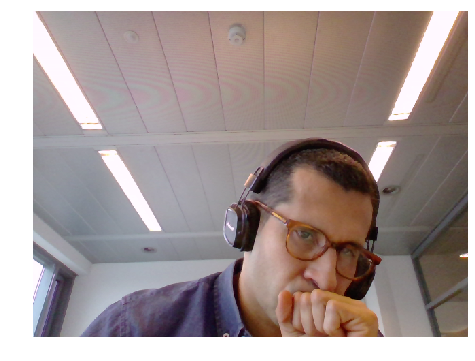

In [5]:
print('Imge type (shoud be int8):', content_img.dtype)
plt.imshow(content_img)
plt.axis('off');

Imge type (shoud be int8): uint8


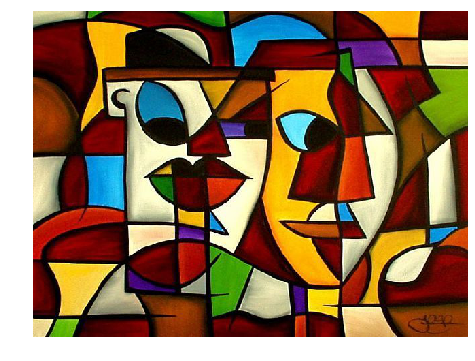

In [6]:
style_img = np.array(image.load_img('picasso_1.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
print('Imge type (shoud be int8):', style_img.dtype)
plt.imshow(style_img)
plt.axis('off');

In [7]:
style_gram_matrices = get_gram_matrix(style_img)

/home/rodrigo/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [8]:
from keras.callbacks import Callback
from IPython.display import clear_output
 
class ShowCombination(Callback):
    def __init__(self, cv2_camera, style_img):
        self.cv2_camera = cv2_camera
        self.style_img = style_img
        
    def on_epoch_begin(self, epoch, logs={}):
        self.content_img = bgr_to_rgb(self.cv2_camera.read()[1])
        self.model.get_layer('combination_tsr').set_weights([np.squeeze(preprocess_image_array(self.content_img))])
        
    def on_epoch_end(self, epoch, logs={}):
        combination_img = deprocess_image_array(self.model.get_layer('combination_tsr').get_weights()[0])
        clear_output()
        plt.imshow(np.hstack((self.content_img, combination_img, self.style_img)))
        plt.axis('off')
        plt.title('Content' + ' ' * 50 + 'Combination' + ' ' * 50 + 'Style')
        plt.show()

In [9]:
learning_rate = 10
model = get_model(style_img, learning_rate)

/home/rodrigo/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [10]:
def input_generator(cv2_camera, style_gram_matrices):
    dummy = np.expand_dims(style_img, axis=0)
    _style_gram_matrices = [np.expand_dims(m, axis=0) for m in style_gram_matrices]
    while True:
        yield dummy, _style_gram_matrices

In [11]:
epochs = 5
steps_per_epoch = 50
model.fit_generator(
    input_generator(CAMERA, style_gram_matrices),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=[ShowCombination(CAMERA, style_img)]
)

Epoch 1/5


ValueError: Error when checking target: expected combination_tsr_style_1_gram to have 3 dimensions, but got array with shape (1, 1, 64, 64)

In [ ]:
# CAMERA.release()